In [101]:
import pandas as pd
import numpy as np
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.api import (
    attach_pipeline,
    calendars,
    pipeline_output,
    date_rules,
    time_rules,
    set_commission, 
    set_slippage,
    record,
    order_target_percent,
    get_open_orders,
    get_datetime,
    schedule_function
)
import pandas_datareader as web
from zipline.finance import commission
from zipline.finance import slippage

In [103]:
# Set the number of longs and shorts and the lookback periods
N_LONGS = N_SHORTS = 50
MONTH = 21
YEAR = 12 * MONTH

In [105]:
# the mean reversion factor
class MeanReversion(CustomFactor):
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR
    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

In [107]:
# implement the function that returns the pipeline using the factor
def make_pipeline():
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(
        columns={
            "longs": mean_reversion.bottom(N_LONGS),
            "shorts": mean_reversion.top(N_SHORTS),
            "ranking": mean_reversion.rank(ascending=False),
        },
        screen=dollar_volume.top(100),
    )

In [109]:
# function that hooks into the event that fires before trading starts
def before_trading_start(context, data):
    context.factor_data = pipeline_output(
        "factor_pipeline")

In [123]:
# function that is invoked when the backtest begins
def initialize(context):
    attach_pipeline(make_pipeline(), "factor_pipeline")
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )
    set_commission(
        us_equities=commission.PerShare(
            cost=0.00075, min_trade_cost=0.01
        )
    )
    set_slippage(
        us_equities=slippage.VolumeShareSlippage(
            volume_limit=0.0025, price_impact=0.01
        )
    )

In [135]:
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)
    # extract the symbols from the 'factor_data' DataFrame and record the asset prices
    assets = factor_data.index
    record(prices=data.current(assets, "price"))
    # identify the assets to go long, to go short, and to divest from the portfolio
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    # we print output to the user and call the 'exec_trades' function to execute our desired orders
    print(
        f"{get_datetime().date()} | Longs {len(longs)} | Shorts | {len(shorts)} | {context.portfolio.portfolio_value}"
    )
    exec_trades(
        data,
        assets=divest,
        target_percent=0
    )
    exec_trades(
        data,
        assets=longs,
        target_percent=1 / N_LONGS
    )
    exec_trades(
        data,
        assets=shorts,
        target_percent=-1 / N_SHORTS
    )

In [137]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [139]:
# function useful to run reports or event trigger alerts if certain thresholds are passed 
def analyze(context, perf):
    perf.portfolio_value.plot()

In [145]:
# compute the daily returns of a benchmark
start = pd.Timestamp("2016-01-01")
end = pd.Timestamp("2018")
sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

C:\Users\tsebo\AppData\Local\Temp\tmp5kad727w\ipykernel_17056\3676248626.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  benchmark_returns = sp500.pct_change()


D:\Anaconda\An\envs\my-quant-stack\lib\site-packages\zipline\utils\events.py:486: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  .view(np.int64)


2016-01-04 | Longs 0 | Shorts | 1 | 100000.0
2016-01-11 | Longs 0 | Shorts | 1 | 99993.16349999886
2016-01-19 | Longs 2 | Shorts | 1 | 100021.36374999832
2016-01-25 | Longs 2 | Shorts | 2 | 100047.47224999769
2016-02-01 | Longs 3 | Shorts | 3 | 99889.9749999967
2016-02-08 | Longs 2 | Shorts | 2 | 99616.54649999554
2016-02-16 | Longs 2 | Shorts | 0 | 99849.90549999391
2016-02-22 | Longs 1 | Shorts | 0 | 100195.42449999285
2016-02-29 | Longs 1 | Shorts | 0 | 100155.76424999181
2016-03-07 | Longs 2 | Shorts | 1 | 100114.18424999181
2016-03-14 | Longs 0 | Shorts | 0 | 100304.28374999072
2016-03-21 | Longs 1 | Shorts | 2 | 99210.60974998782
2016-03-28 | Longs 1 | Shorts | 0 | 99355.18649998584
2016-04-04 | Longs 1 | Shorts | 0 | 99108.98424998432
2016-04-11 | Longs 2 | Shorts | 1 | 99483.63424998433
2016-04-18 | Longs 2 | Shorts | 0 | 99556.3877499843
2016-04-25 | Longs 2 | Shorts | 0 | 99573.0884999835
2016-05-02 | Longs 4 | Shorts | 0 | 99557.5844999825
2016-05-09 | Longs 3 | Shorts | 1 |

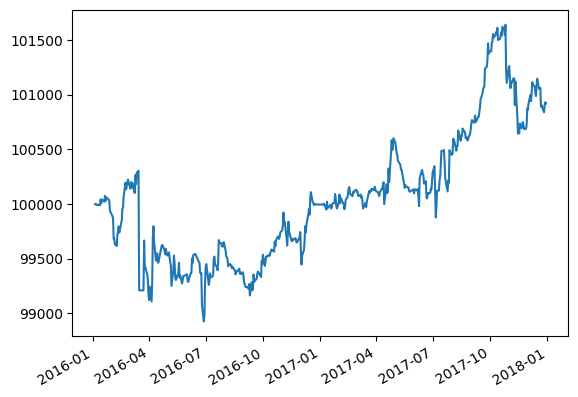

In [146]:
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    benchmark_returns=benchmark_returns,
    before_trading_start=before_trading_start,
    capital_base=100000,
    bundle="quandl"
)
perf.to_pickle("mean_reversion.pickle")